In [1]:
!pip install tensorflow==2.0.0a0

  Using cached https://files.pythonhosted.org/packages/c7/90/cf5e7fbf4a3c14b314e1ed6571eae1f9ad3b5e32a4e24b2b817466435a21/tensorflow-2.0.0a0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/13/82/f16063b4eed210dc2ab057930ac1da4fbe1e91b7b051a6c8370b401e6ae7/tf_estimator_nightly-1.14.0.dev2019030115-py2.py3-none-any.whl


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acesso negado: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\tensorflow_estimator\\__init__.py'
Consider using the `--user` option or check the permissions.



##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy import stats

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
df = pd.read_csv('14046_2teste.csv',sep=',',encoding='UTF-8')

Let's take a glance at the data.

In [5]:
df.head()

,t,mV
0,0.000,0.16
1,0.008,0.18
2,0.016,0.17
3,0.023,0.18
4,0.031,0.18


As you can see above, an observation is recorded every 0.008 seconds. 

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [7]:
df.shape

(19337, 2)

In [8]:
TRAIN_SPLIT = int(df.shape[0]*0.4)

Setting seed to ensure reproducibility.

In [9]:
TRAIN_SPLIT

7734

In [10]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [11]:
df.head(3)

,t,mV
0,0.000,0.16
1,0.008,0.18
2,0.016,0.17


In [12]:
uni_data = df['mV']
uni_data.index = df['t']
uni_data.head()

t
0.000    0.16
0.008    0.18
0.016    0.17
0.023    0.18
0.031    0.18
Name: mV, dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026C00026648>],
      dtype=object)

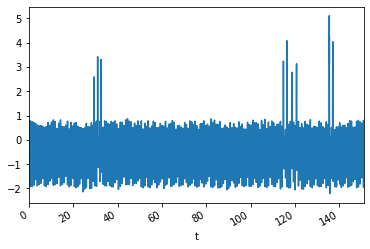

In [13]:
uni_data.plot(subplots=True)

In [14]:
uni_data = uni_data.values

In [15]:
uni_data

array([0.16, 0.18, 0.17, ..., 0.08, 0.09, 0.09])

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [16]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [17]:
uni_train_mean

-0.012189035427980345

In [18]:
uni_train_std

0.34154981501279336

Let's standardize the data.

In [19]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [20]:
uni_data

array([0.50414033, 0.56269694, 0.53341863, ..., 0.26991388, 0.29919218,
       0.29919218])

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [21]:
univariate_past_history = 15
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [22]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target mV to predict')
print (y_train_uni[0])

Single window of past history
[[ 0.50414033]
 [ 0.56269694]
 [ 0.53341863]
 [ 0.56269694]
 [ 0.56269694]
 [ 0.53341863]
 [ 0.53341863]
 [ 0.41630541]
 [ 0.41630541]
 [ 0.32847049]
 [ 0.21135727]
 [ 0.15280065]
 [ 0.06496574]
 [ 0.00640912]
 [-0.02286918]]

 Target mV to predict
-0.022869181093619045


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [23]:
def create_time_steps(length):
    return list(range(-length, 0))

In [24]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

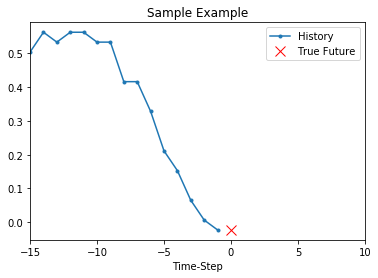

In [25]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [26]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

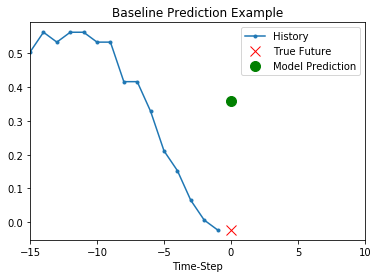

In [27]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [28]:
BATCH_SIZE = 1000
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](images/time_series.png)

You will see the LSTM requires the input shape of the data it is being given.

In [29]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [30]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(1000, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [31]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 0.3464 - val_loss: 0.3175
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2504 - val_loss: 0.2529
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2099 - val_loss: 0.2190
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1841 - val_loss: 0.1975
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1722 - val_loss: 0.1919
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1675 - val_loss: 0.1879
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1640 - val_loss: 0.1841
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1596 - val_loss: 0.1793
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.1552 - val_loss: 0.1747
Epoch 10/10
200/200 [===========================

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

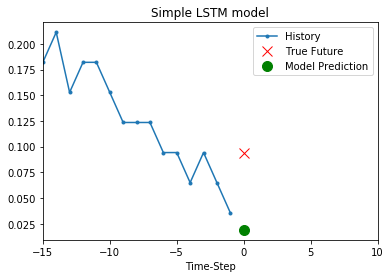

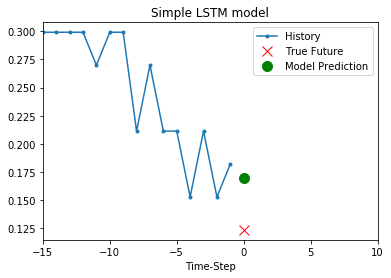

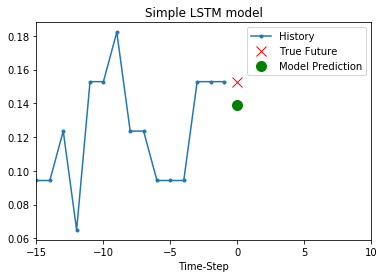

In [32]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [33]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

### Multi-Step model for 15 past history per run (Going to stress and see how well it performs)

In [34]:
univariate_past_history = 15
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Let's check out a sample data-point.

In [35]:
print ('Single window of past history : {}'.format(x_train_uni[0].shape))
print ('\n Target mV to predict : {}'.format(y_train_uni.shape))

Single window of past history : (15, 1)

 Target mV to predict : (7719,)


In [36]:
STEP = 1
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [37]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

In [38]:
len(y)

1000

### Gotta fix x/y ranges

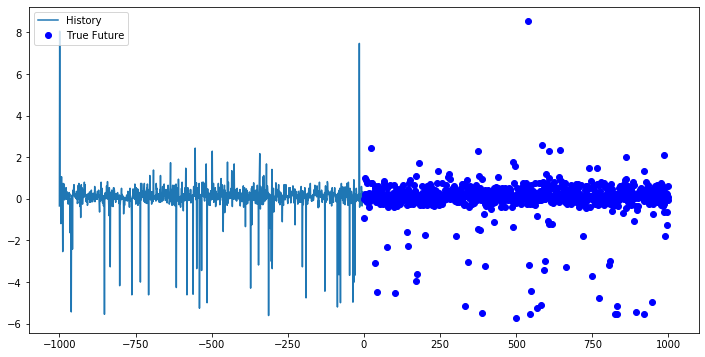

In [39]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x, y, np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [40]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(256))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [41]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(1000, 256)


In [42]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=100,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 7s 67ms/step - loss: 0.3674 - val_loss: 0.3588
Epoch 2/10
100/100 [==============================] - 5s 45ms/step - loss: 0.2979 - val_loss: 0.3005
Epoch 3/10
100/100 [==============================] - 5s 45ms/step - loss: 0.2502 - val_loss: 0.2551
Epoch 4/10
100/100 [==============================] - 5s 45ms/step - loss: 0.2137 - val_loss: 0.2155
Epoch 5/10
100/100 [==============================] - 5s 46ms/step - loss: 0.1883 - val_loss: 0.2006
Epoch 6/10
100/100 [==============================] - 4s 45ms/step - loss: 0.1715 - val_loss: 0.1838
Epoch 7/10
100/100 [==============================] - 4s 44ms/step - loss: 0.1524 - val_loss: 0.1593
Epoch 8/10
100/100 [==============================] - 4s 44ms/step - loss: 0.1340 - val_loss: 0.1439
Epoch 9/10
100/100 [==============================] - 4s 44ms/step - loss: 0.1193 - val_loss: 0.1307
Epoch 10/10
100/100 [===========================

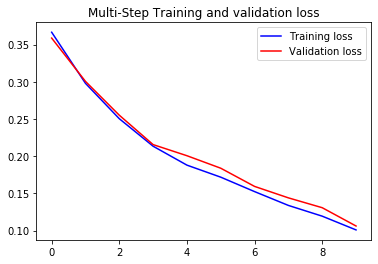

In [43]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

### With a 15 window of past history, and a 100 steps per epoch we are getting a 86.5% Score and the following measures:

In [44]:
val_data_multi.take(5)

<TakeDataset shapes: ((None, 15, 1), (None,)), types: (tf.float64, tf.float64)>

# BUFFER SIZE = The ammount to be predicted

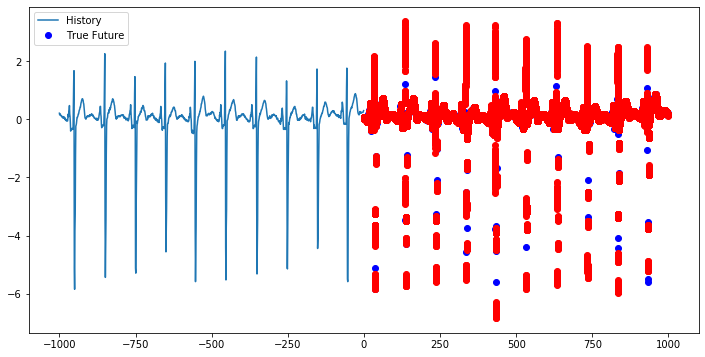

Pearsonr Correlation:


ValueError: x and y must have the same length.

In [45]:
for x, y in val_data_multi.take(5):
    multi_step_plot(x, y, multi_step_model.predict(x))
    print('Pearsonr Correlation:')
    print(stats.pearsonr(multi_step_model.predict(x)[0],y))
    print('TTest:')
    print(stats.ttest_ind(multi_step_model.predict(x)[0],y))
    print('Chi Square:')
    print(stats.chisquare(multi_step_model.predict(x)[0],y))

In [46]:
X_train,X_test = train_test_split(df,test_size=0.3)

In [47]:
df = pd.read_csv('14046_2teste.csv',sep=',',encoding='UTF-8')

Let's take a glance at the data.

In [48]:
df.head()

,t,mV
0,0.000,0.16
1,0.008,0.18
2,0.016,0.17
3,0.023,0.18
4,0.031,0.18


As you can see above, an observation is recorded every 0.008 seconds. 

In [49]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [50]:
df.shape

(19337, 2)

In [51]:
TRAIN_SPLIT = int(df.shape[0]*0.3)

Setting seed to ensure reproducibility.

In [52]:
TRAIN_SPLIT

5801

In [53]:
tf.random.set_seed(13)

In [54]:
univariate_past_history = 5
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Let's check out a sample data-point.

In [55]:
print ('Single window of past history : {}'.format(x_train_uni[0].shape))
print ('\n Target mV to predict : {}'.format(y_train_uni.shape))

Single window of past history : (5, 1)

 Target mV to predict : (5796,)


In [56]:
STEP = 1
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [57]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

In [58]:
len(y)

1000

### Gotta fix x/y ranges

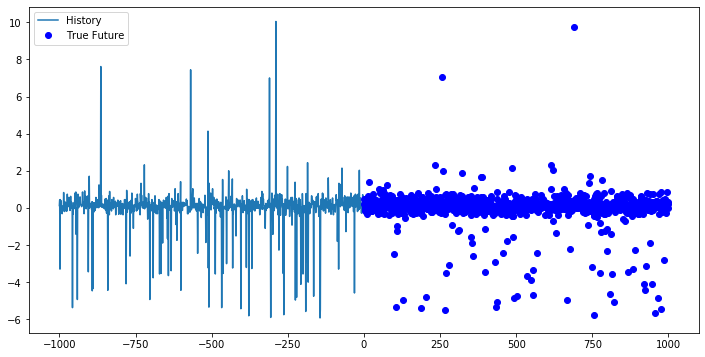

In [59]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x, y, np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [60]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(256))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [61]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(1000, 256)


In [62]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=100,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 4s 39ms/step - loss: 0.3680 - val_loss: 0.2761
Epoch 2/10
100/100 [==============================] - 2s 19ms/step - loss: 0.2438 - val_loss: 0.2321
Epoch 3/10
100/100 [==============================] - 2s 17ms/step - loss: 0.2239 - val_loss: 0.2209
Epoch 4/10
100/100 [==============================] - 2s 19ms/step - loss: 0.2085 - val_loss: 0.2042
Epoch 5/10
100/100 [==============================] - 2s 19ms/step - loss: 0.1891 - val_loss: 0.1803
Epoch 6/10
100/100 [==============================] - 2s 19ms/step - loss: 0.1709 - val_loss: 0.1696
Epoch 7/10
100/100 [==============================] - 2s 19ms/step - loss: 0.1636 - val_loss: 0.1601
Epoch 8/10
100/100 [==============================] - 2s 18ms/step - loss: 0.1592 - val_loss: 0.1585
Epoch 9/10
100/100 [==============================] - 2s 18ms/step - loss: 0.1551 - val_loss: 0.1535
Epoch 10/10
100/100 [===========================

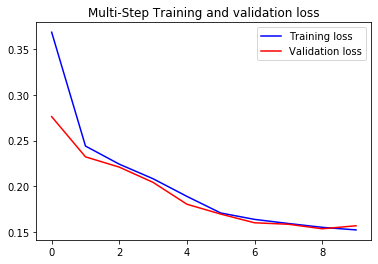

In [63]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

### With a 5 Window past history we begin to lose performance now going to an score of 86%

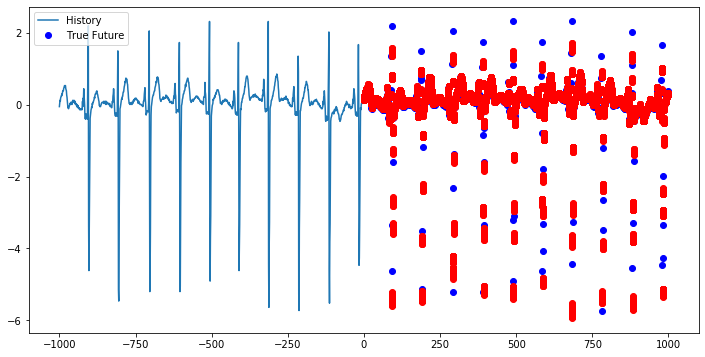

Pearsonr Correlation:


ValueError: x and y must have the same length.

In [64]:
for x, y in val_data_multi.take(5):
    multi_step_plot(x, y, multi_step_model.predict(x))
    print('Pearsonr Correlation:')
    print(stats.pearsonr(multi_step_model.predict(x)[0],y))
    print('TTest:')
    print(stats.ttest_ind(multi_step_model.predict(x)[0],y))
    print('Chi Square:')
    print(stats.chisquare(multi_step_model.predict(x)[0],y))

Let's take a glance at the data.

In [ ]:
df.head()

As you can see above, an observation is recorded every 0.008 seconds. 

In [65]:
univariate_past_history = 3
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Let's check out a sample data-point.

In [66]:
print ('Single window of past history : {}'.format(x_train_uni[0].shape))
print ('\n Target mV to predict : {}'.format(y_train_uni.shape))

Single window of past history : (3, 1)

 Target mV to predict : (5798,)


In [67]:
STEP = 1
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))

In [68]:
train_data_multi

<TensorSliceDataset shapes: ((3, 1), ()), types: (tf.float64, tf.float64)>

In [69]:
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [70]:
train_data_multi

<RepeatDataset shapes: ((None, 3, 1), (None,)), types: (tf.float64, tf.float64)>

In [71]:
val_data_multi

<RepeatDataset shapes: ((None, 3, 1), (None,)), types: (tf.float64, tf.float64)>

Plotting a sample data-point.

In [426]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

### Gotta fix x/y ranges

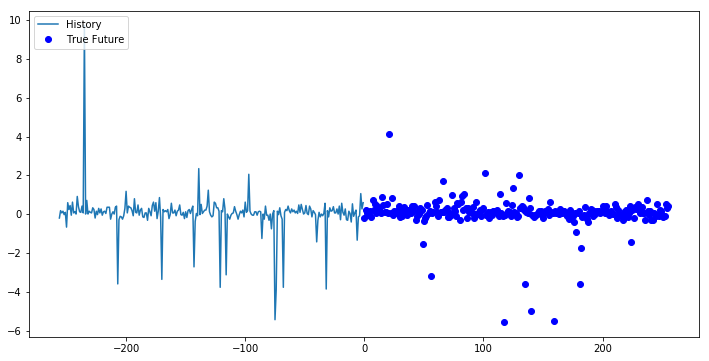

In [427]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x, y, np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [428]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(256))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [429]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 256)


In [430]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=10,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
10/10 [==============================] - 5s 534ms/step - loss: 0.4293 - val_loss: 0.4598
Epoch 2/10
10/10 [==============================] - 1s 59ms/step - loss: 0.4540 - val_loss: 0.4480
Epoch 3/10
10/10 [==============================] - 1s 58ms/step - loss: 0.4156 - val_loss: 0.4312
Epoch 4/10
10/10 [==============================] - 1s 56ms/step - loss: 0.4145 - val_loss: 0.4131
Epoch 5/10
10/10 [==============================] - 1s 56ms/step - loss: 0.4066 - val_loss: 0.4032
Epoch 6/10
10/10 [==============================] - 1s 57ms/step - loss: 0.3704 - val_loss: 0.3930
Epoch 7/10
10/10 [==============================] - 1s 57ms/step - loss: 0.3979 - val_loss: 0.3822
Epoch 8/10
10/10 [==============================] - 1s 57ms/step - loss: 0.3761 - val_loss: 0.3697
Epoch 9/10
10/10 [==============================] - 1s 55ms/step - loss: 0.3548 - val_loss: 0.3599
Epoch 10/10
10/10 [==============================] - 1s 56ms/step - loss: 0.3406 - val_loss: 0.3469


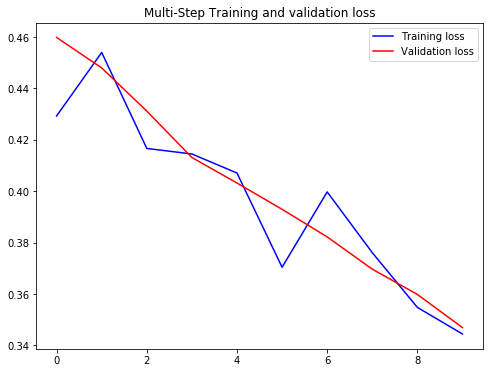

In [431]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

### Lastly training our data on a window of 3 past history  our error goes all the way down to 65% of score

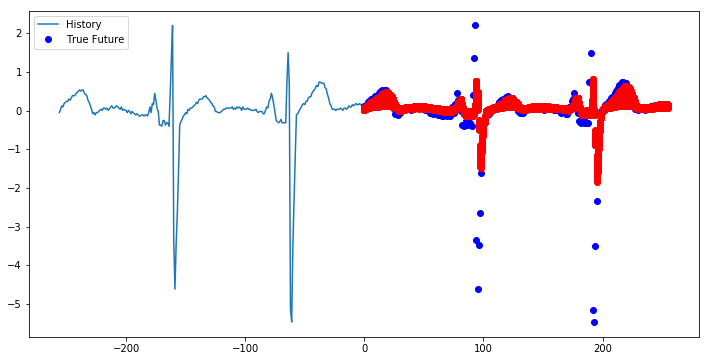

Pearsonr Correlation:
(-0.029816247200269274, 0.6349075052726305)
TTest:
Ttest_indResult(statistic=1.133688966814697, pvalue=0.25745766477306564)
Chi Square:
Power_divergenceResult(statistic=-19.093632813103383, pvalue=1.0)


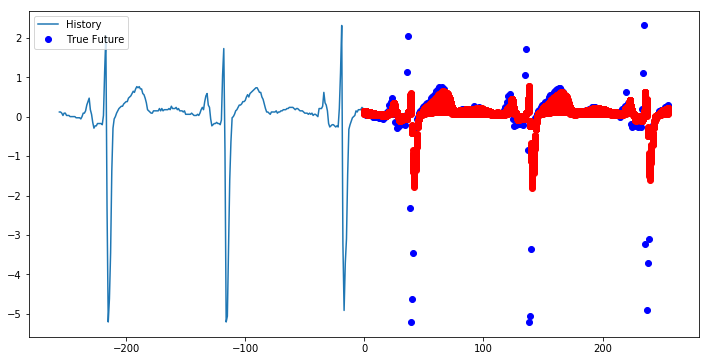

Pearsonr Correlation:
(0.000667382107627231, 0.991521951422843)
TTest:
Ttest_indResult(statistic=2.1509355003799264, pvalue=0.03195042762456818)
Chi Square:
Power_divergenceResult(statistic=-26.556896114714966, pvalue=1.0)


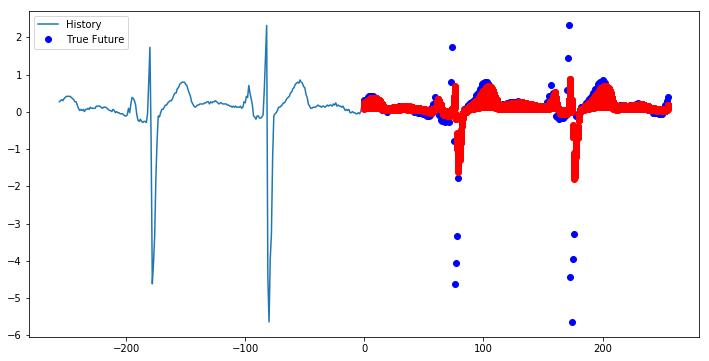

Pearsonr Correlation:
(-0.06961527543290834, 0.2671109403335587)
TTest:
Ttest_indResult(statistic=2.3097578560961503, pvalue=0.021300043521310996)
Chi Square:
Power_divergenceResult(statistic=-30.44115648693209, pvalue=1.0)


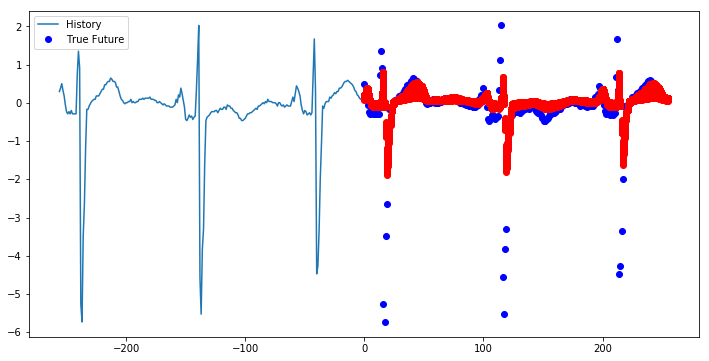

Pearsonr Correlation:
(-0.04823022365513411, 0.44227667966717554)
TTest:
Ttest_indResult(statistic=5.443780888525639, pvalue=8.118373652651816e-08)
Chi Square:
Power_divergenceResult(statistic=-42.52625200209833, pvalue=1.0)


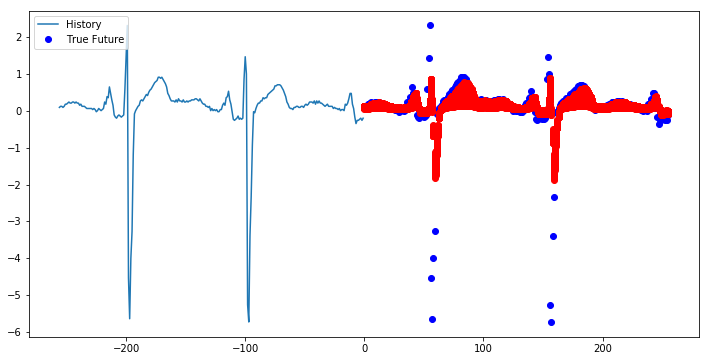

Pearsonr Correlation:
(0.01879753337090548, 0.7646996215286893)
TTest:
Ttest_indResult(statistic=0.6328775895577097, pvalue=0.5270972433560349)
Chi Square:
Power_divergenceResult(statistic=-7.49086025224949, pvalue=1.0)


In [432]:
for x, y in val_data_multi.take(5):
    multi_step_plot(x, y, multi_step_model.predict(x))
    print('Pearsonr Correlation:')
    print(stats.pearsonr(multi_step_model.predict(x)[0],y))
    print('TTest:')
    print(stats.ttest_ind(multi_step_model.predict(x)[0],y))
    print('Chi Square:')
    print(stats.chisquare(multi_step_model.predict(x)[0],y))